In [1]:
%pip install scikit-learn optuna prettytable matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

In [4]:
import tensorflow as tf

2025-02-21 13:31:30.465528: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 13:31:30.554187: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 13:31:30.637890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740124890.655247    5444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740124890.659454    5444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 13:31:30.676136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
print(tf.__version__)
print(np.__version__)

2.18.0
2.0.2


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split

In [7]:
def get_mlp_model(input_shape,hidden_layer_one,dropout_one,hidden_layer_two,dropout_two):
    model = Sequential()
    model.add(Dense(hidden_layer_one, activation='elu', input_shape=input_shape))
    if dropout_one !=0:
        model.add(Dropout(dropout_one))
    model.add(Dense(hidden_layer_two, activation='elu'))
    if dropout_two !=0:
        model.add(Dropout(dropout_two))
    model.add(Dense(1))
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer="Adam")

    return model

In [8]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    rrse = np.sqrt(np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    mape = np.mean(np.abs((predicted - trues) / trues)) * 100
    r2 = max(0, 1 - np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    # Calculez les autres mesures d'erreur ici
    return rmse, corr, mae, rae, rrse, mape, r2

## load and aggregate data by month

In [9]:
order_history_data=pd.read_csv('../data/final_data.csv')
order_history_data.head()

,Inflation,Month,Year,pmi,PartNo,Description,Quantity,Sales Price,Total Sales,Swaraj Engines Stock Price,M&M Stock Price,Escorts Kuboto Stock Price
0,7.59,1,2020,250,0503BA0290N-RK,ALFA HUB,85,2118.60,59367,1125.0,532.9,630.0
1,7.59,1,2020,250,0503BA0290N,Front Wheel Hub,318,3536.35,59367,1125.0,532.9,630.0
2,7.59,1,2020,250,0502BA1050N,Alfa Rear Wheel Hub LH,209,1383.36,59367,1125.0,532.9,630.0
3,7.59,1,2020,250,0502BA1060N,Alfa Rear Wheel Hub RH,119,4849.50,59367,1125.0,532.9,630.0
4,7.59,1,2020,250,0602AAB00260N,Brake Drum ALFA,134,2462.26,59367,1125.0,532.9,630.0


In [10]:
X = order_history_data.copy()
y = order_history_data['Quantity']

X_encoded = pd.get_dummies(X, columns=['Description', 'PartNo'])

_, X_temp, _, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=27)
_, X_test, _, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

## Load the optimized model, make predictions on the test data and calculate the errors. You can then compare performance with other models, such as the reference models created previously.

In [11]:
hidden_layer_one=50
hidden_layer_two=100
dropout_one=0
dropout_two=0


model=get_mlp_model(input_shape=(X_test.shape[1],),hidden_layer_one=hidden_layer_one,dropout_one=dropout_one,hidden_layer_two=hidden_layer_two,dropout_two=dropout_two)


checkpoint_filepath = '../checkpoint/base_model_checkpoint.weights.h5'
# checkpoint_filepath = 'model_checkpoint.h5'

# Load the best weights from the saved checkpoint
model.load_weights(checkpoint_filepath)

# Evaluate the performance of the model on the test set
y_test_pred = model.predict(X_test)

# Calculate performance metrics
rmse2, corr2, mae2, rae2, rrse2, mape2, r2_2 = compute_error(y_test.values, y_test_pred.reshape(y_test_pred.shape[0]))
print("RMSE:", rmse2)
print("Corrélation:", corr2)
print("MAE:", mae2)
print("RAE:", rae2)
print("RRSE:", rrse2)
print("MAPE:", mape2)
print("R2:", r2_2)
print("----------------------------------")



49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1740124893.291951    5444 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.g

RMSE: 1.3380370855580126
Corrélation: 0.9999613345000999
MAE: 0.9244380799727908
RAE: 0.007495515275676247
RRSE: 0.008926473702537446
MAPE: 0.6340294022629149
R2: 0.9999203180672379
----------------------------------


**Performance comparaison**

In [12]:
from prettytable import PrettyTable


table = PrettyTable()
table.field_names = ["Model", "RMSE", "Correlation", "MAE", "RAE", "RRSE", "MAPE", "R2"]

table.add_row(["Random Forest", 23.3435, 0.812994, 8.96228, 0.504168, 0.58709, 82.339, 0.655325])
table.add_row(["Linear Regression", 23.8307, 0.802579, 11.2327, 0.631891, 0.599343, 218.499, 0.640788])
table.add_row(["Lasso", 33.9357, 0.547551, 15.9419, 0.896799, 0.853486, 365.006, 0.271562])
table.add_row(["Ridge", 23.8388, 0.801596, 11.1452, 0.626969, 0.599547, 214.896, 0.640543])
table.add_row(["ElasticNet", 38.4939, 0.251833, 17.1119, 0.962617, 0.968125, 397.283, 0.0627341])
table.add_row(["KNN", 26.1298, 0.765809, 10.7885, 0.606903, 0.657167, 142.926, 0.568132])

stock_management_row = ["Stock Management Model", 17.1057, "\033[1;32m0.923358\033[0m", 7.52769, 0.406239, 0.3849, 120.014, "\033[1;32m0.85185\033[0m"]
table.add_row(stock_management_row)

table.align = "c"
table.hrules = True
table.horizontal_char = "─"
table.vertical_char = "│"
table.junction_char = "┼"

print(table)


┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Model          │   RMSE  │ Correlation │   MAE   │   RAE    │   RRSE   │   MAPE  │     R2    │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│     Random Forest      │ 23.3435 │   0.812994  │ 8.96228 │ 0.504168 │ 0.58709  │  82.339 │  0.655325 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│   Linear Regression    │ 23.8307 │   0.802579  │ 11.2327 │ 0.631891 │ 0.599343 │ 218.499 │  0.640788 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Lasso          │ 33.9357 │   0.547551  │ 15.9419 │ 0.896799 │ 0.853486 │ 365.006 │  0.271562 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Ridge          │ 23.8388 │   0.801596  │ 11.1

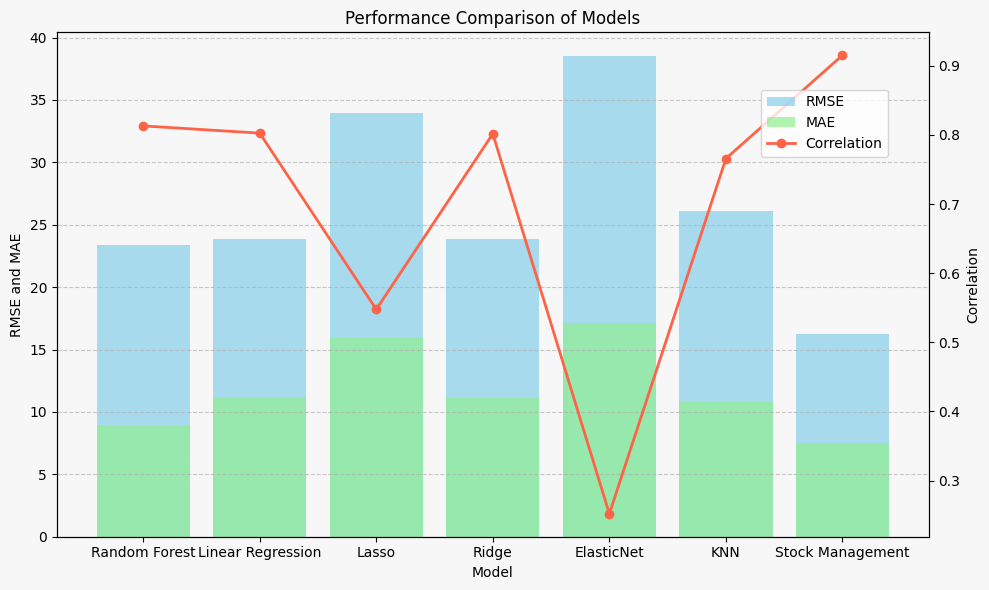

In [13]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'KNN', 'Stock Management']
rmse = [23.3435, 23.8307, 33.9357, 23.8388, 38.4939, 26.1298, 16.2239]
correlation = [0.812994, 0.802579, 0.547551, 0.801596, 0.251833, 0.765809, 0.915217]
mae = [8.96228, 11.2327, 15.9419, 11.1452, 17.1119, 10.7885, 7.52769]



fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.bar(models, rmse, color='skyblue', alpha=0.7, label='RMSE')
ax1.bar(models, mae, color='lightgreen', alpha=0.7, label='MAE')


ax2 = ax1.twinx()
ax2.plot(models, correlation, color='tomato', marker='o', label='Correlation', linewidth=2)


ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE and MAE', color='black')
ax2.set_ylabel('Correlation', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')


ax1.grid(axis='y', linestyle='--', alpha=0.7)


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.8, 0.9))


plt.title('Performance Comparison of Models')
plt.tight_layout()

ax1.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('#f7f7f7')


plt.show()
